# Using K_means algorithm to recognise color in image

This  Jupyter notebook "k_mean primary color.ipynb" is designed to perform color analysis on a set of images. 
It uses the k-means clustering algorithm to identify the primary colors in each image. 

## Import libraries

Necessary libraries. They are :
- `sklearn` for KMeans algorithm, 
- `matplotlib.pyplot` for plotting graphs, 
- `numpy` to work with arrays, 
- `cv2` to work with image data, 
- `collections` to use Counter to count values, 
- `rgb2lab` to convert RGB values and 
- `deltaE_cie76` to calculate similarity between colors.

In [1]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import cv2
from collections import Counter
from skimage.color import rgb2lab, deltaE_cie76
import os

## Load the image 

Import one image in jpg form

The type of this input is <class 'numpy.ndarray'>
Shape: (100, 100, 3)


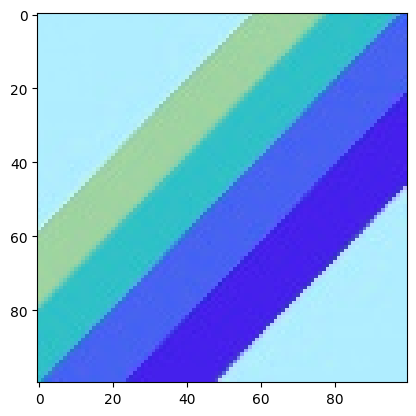

In [2]:
image = cv2.imread('images_jpg\\colors.jpg')
if image is None:
    print("Failed to load image")
else:
    print("The type of this input is {}".format(type(image)))
    print("Shape: {}".format(image.shape))
    plt.imshow(image)

### Note
The image appears to have altered colors when compared to the original. This discrepancy arises because OpenCV, by default, processes images in the BLUE GREEN RED (BGR) color sequence. Therefore, we need to adjust this to the RED GREEN BLUE (RGB) sequence to maintain the original color representation.

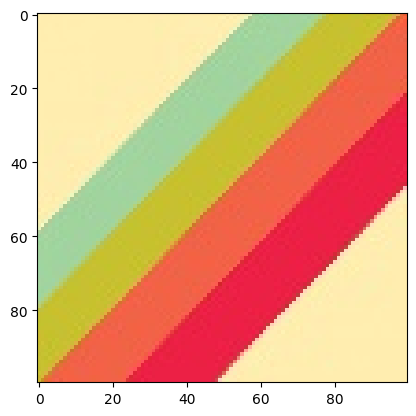

In [3]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

### Note
In cases where we are dealing with large images or multiple images of varying dimensions, it may be beneficial to resize the images to a consistent size.

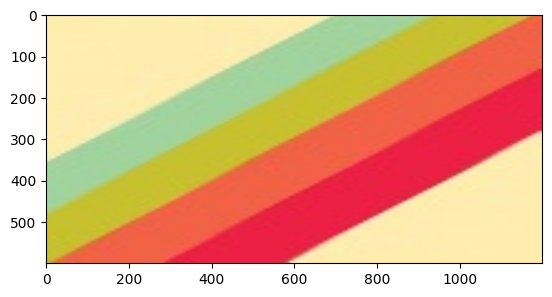

In [4]:
resized_image = cv2.resize(image, (1200, 600))
plt.imshow(resized_image)

## Color Identification (1 primary color)

I use this function in order to take the `hex` values of the colors that I will identify.

In [5]:
def RGB2HEX(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))

def load_image(image_path) : reads an image from the provided path and converts it from BGR -> RGB color space

In [6]:
def load_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

### Note
I will plot the data points in 3D space using python matplotlib in order to see the pixels how they are in the space

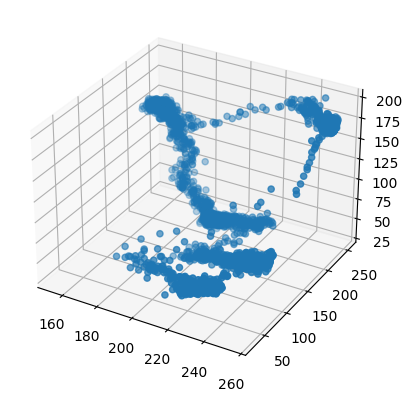

In [7]:
%matplotlib inline

#get rgb values from image to 1D array
r, g, b = cv2.split(image)
r = r.flatten()
g = g.flatten()
b = b.flatten()

#plotting 
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(r, g, b)
plt.show()

### Run Kmean algorithm , number of clusters according to <u>the number of dominant colors that we want</u> ( 1st option)
#### extract_colors(image, number_of_colors, show_chart): does the main work of color extraction.

In [8]:
def extract_colors(image, number_of_colors, show_chart):
    
    # resize the image to speed up processing time
    #interpolation is a metod to reduce the size of the image while keeping the quality good
    modified_image = cv2.resize(image, (600, 400), interpolation = cv2.INTER_AREA)
    # change the shape of the image, before it was 3D array(height, width, color channels), now it is 2D array(number of pixels, color channels)
    modified_image = modified_image.reshape(modified_image.shape[0]*modified_image.shape[1], 3)
    
    # create the model
    clf = KMeans(n_clusters = number_of_colors)
    labels = clf.fit_predict(modified_image) # fit the model to the image data and predicts the cluster for each pixel
    # more specifcally, if we have 3 clusters, the labels will be 0, 1, 2, and each pixel will be assigned to one of these clusters, so if a particular pixel has label 0, it means it belongs to the first cluster
    
    counts = Counter(labels) # counts the number of pixels in each cluster
    counts = dict(sorted(counts.items())) # sort to ensure correct color percentage
    
    # get the cluster centers
    center_colors = clf.cluster_centers_
    # We get ordered colors by iterating through the keys
    ordered_colors = [center_colors[i] for i in counts.keys()] # orders the colors according to the sorted keys of the counts dictionary
    hex_colors = [RGB2HEX(ordered_colors[i]) for i in counts.keys()] # converts the RGB colors to HEX
    rgb_colors = [ordered_colors[i] for i in counts.keys()] # gets the RGB colors

    # show the chart
    if (show_chart):
        plt.figure(figsize = (8, 6)) # set the size of the chart
        plt.pie(counts.values(), labels = hex_colors, colors = hex_colors) # create the pie chart
    
    return rgb_colors ,labels

### Call the function with the number of dominant colors that you want to appeared

c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


([array([233.23280098,  33.57739558,  67.39189189]),
  array([253.92475884, 236.70418006, 175.82797428]),
  array([199.96876712, 191.1709589 ,  50.83342466]),
  array([163.52706553, 210.8974359 , 154.95156695]),
  array([240.21839646,  99.09837678,  69.86866699])],
 array([1, 1, 1, ..., 1, 1, 1]))

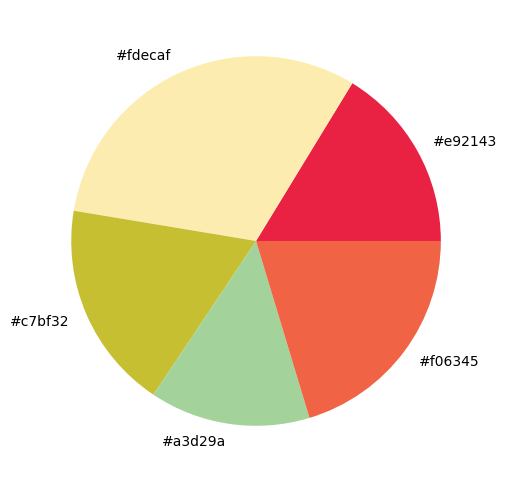

In [9]:
extract_colors(load_image('images_jpg\\colors.jpg'), 5, True)

### New Plot with the Colors - 1st Option

c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


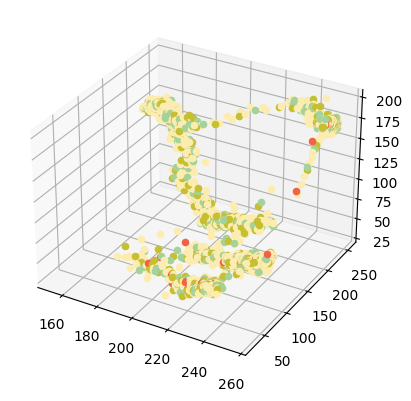

In [13]:
def visualize_clusters(image, labels, colors):
    r, g, b = cv2.split(image)
    r = r.flatten()
    g = g.flatten()
    b = b.flatten()

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    for label, pix in zip(labels, zip(r, g, b)):
        ax.scatter(pix[0], pix[1], pix[2], color = RGB2HEX(colors[label]))
    plt.show()

rgb_colors, labels = extract_colors(image, number_of_colors=5, show_chart=False)
visualize_clusters(image, labels, rgb_colors)

### Show which color is most effective 
it means which clusters has the most data points 

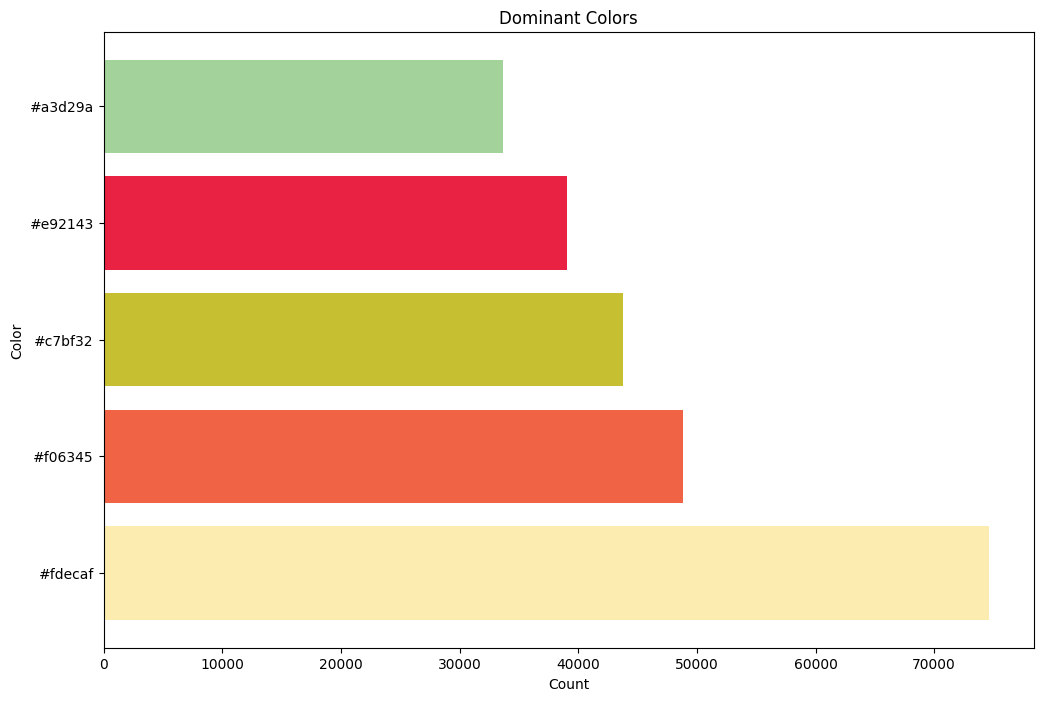

In [14]:
def display_dominant_colors(counts, hex_colors):
    # sort the counts dictionary in descending order
    sorted_counts = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))

    # create lists for colors and their counts
    dominant_colors = [hex_colors[i] for i in sorted_counts.keys()]
    counts = list(sorted_counts.values())

    # create a bar chart
    plt.figure(figsize=(12, 8))
    plt.barh(dominant_colors, counts, color=dominant_colors)
    plt.xlabel('Count')
    plt.ylabel('Color')
    plt.title('Dominant Colors')
    plt.show()
    
# Count labels
counts = Counter(labels)

# Convert RGB colors to HEX
hex_colors = [RGB2HEX(rgb_color) for rgb_color in rgb_colors]

# Display dominant colors
display_dominant_colors(counts, hex_colors)

### Run Kmean algorithm using <u>the Elbow method</u> to find the number of clusters ( 2nd option)
#### extract_colors_elbow(image, show_chart):

In [19]:
from kneed import KneeLocator # to find the elbow point in the elbow method

def extract_colors_elbow(image, show_chart):
    # resize and reshape the image as before
    modified_image = cv2.resize(image, (600, 400), interpolation = cv2.INTER_AREA)
    modified_image = modified_image.reshape(modified_image.shape[0]*modified_image.shape[1], 3) # reshape the image to 2D array ( where each row is a pixel and each column is 
    # a color channel RGB ) to be able to use it in the elbow method to find the optimal number of clusters

    # use the elbow method to find the optimal number of clusters
    distortions = [] # to store the distortions - the sum of the squared distances between each member of the cluster and its centroid
    K = range(1,10) # the range of the number of clusters - OPTIMAL NUMBER
    for k in K: # for each number of clusters
        kmeanModel = KMeans(n_clusters=k) # create the model
        kmeanModel.fit(modified_image) # fit the model to the image data
        distortions.append(kmeanModel.inertia_) # append the distortion to the list

    # plot the elbow
    plt.figure(figsize=(16,8))
    plt.plot(K, distortions, 'bx-') # plot the number of clusters vs the distortions
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

    # find the elbow point
    kn = KneeLocator(K, distortions, curve='convex', direction='decreasing')
    number_of_colors = kn.knee # get the optimal number of clusters
    
    # Print the optimal number of clusters
    print(f'The optimal number of clusters is {number_of_colors}')

    # create the model with the optimal number of clusters
    clf = KMeans(n_clusters = number_of_colors)
    labels = clf.fit_predict(modified_image) # fit the model to the image data and predicts the cluster for each pixel

    counts = Counter(labels) # counts the number of pixels in each cluster
    counts = dict(sorted(counts.items())) # sort the counts by cluster number

    center_colors = clf.cluster_centers_ # get the cluster centers- the center color of each cluster
    ordered_colors = [center_colors[i] for i in counts.keys()] # orders the colors according to the sorted keys of the counts dictionary
    hex_colors = [RGB2HEX(ordered_colors[i]) for i in counts.keys()] # converts the RGB colors to HEX
    rgb_colors = [ordered_colors[i] for i in counts.keys()] # gets the RGB colors

    if (show_chart):
        plt.figure(figsize = (8, 6))
        plt.pie(counts.values(), labels = hex_colors, colors = hex_colors)

    return rgb_colors ,labels

c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_in

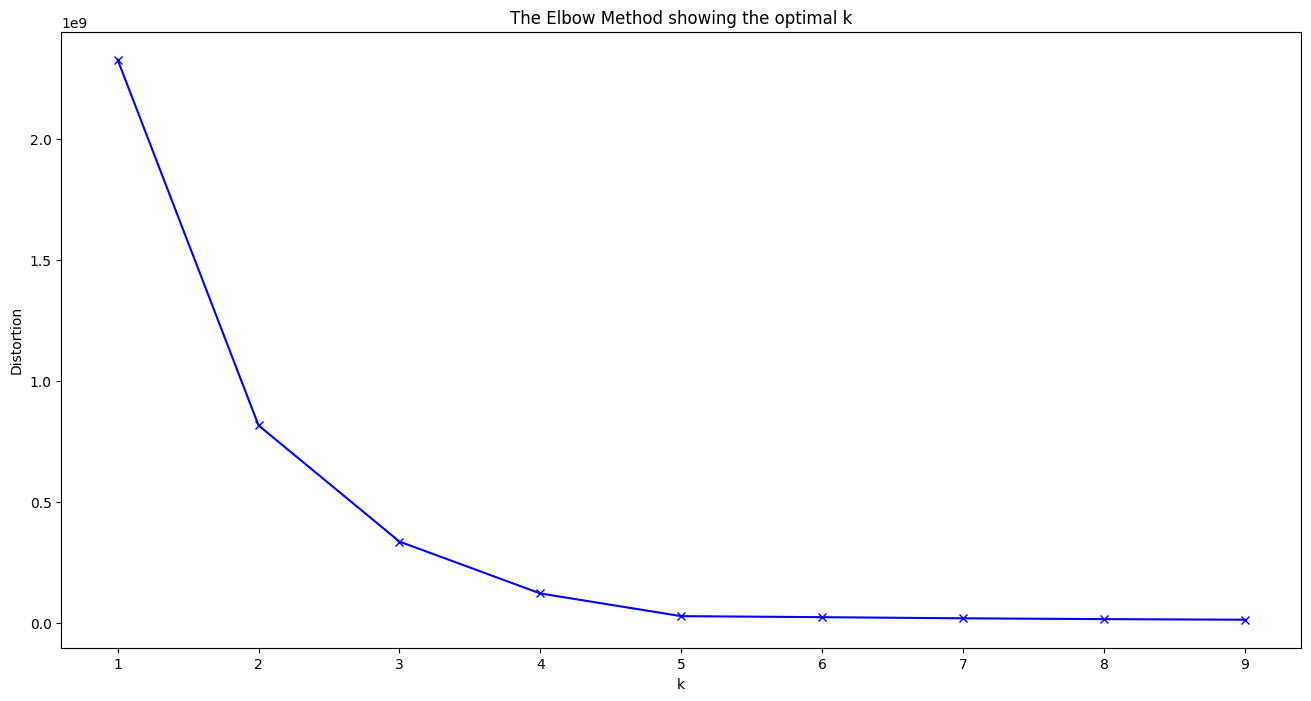

The optimal number of clusters is 3


c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


([array([226.11742424, 228.76782531, 169.6847148 ]),
  array([237.24127508,  69.57653201,  68.8224787 ]),
  array([199.77148959, 190.80032034,  51.74319274])],
 array([0, 0, 0, ..., 0, 0, 0]))

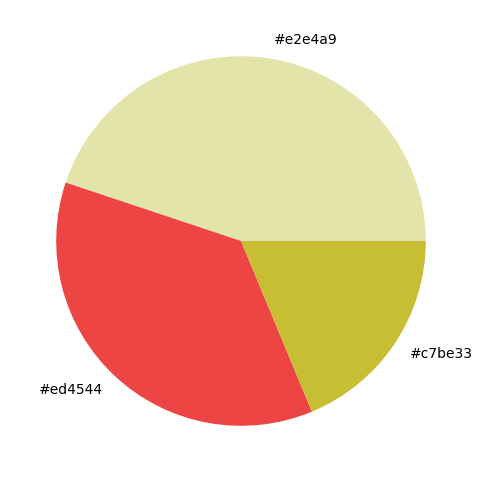

In [20]:
extract_colors_elbow(load_image('images_jpg\\colors.jpg'), True)

### New Plot with the Colors - 2nd Option

c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_in

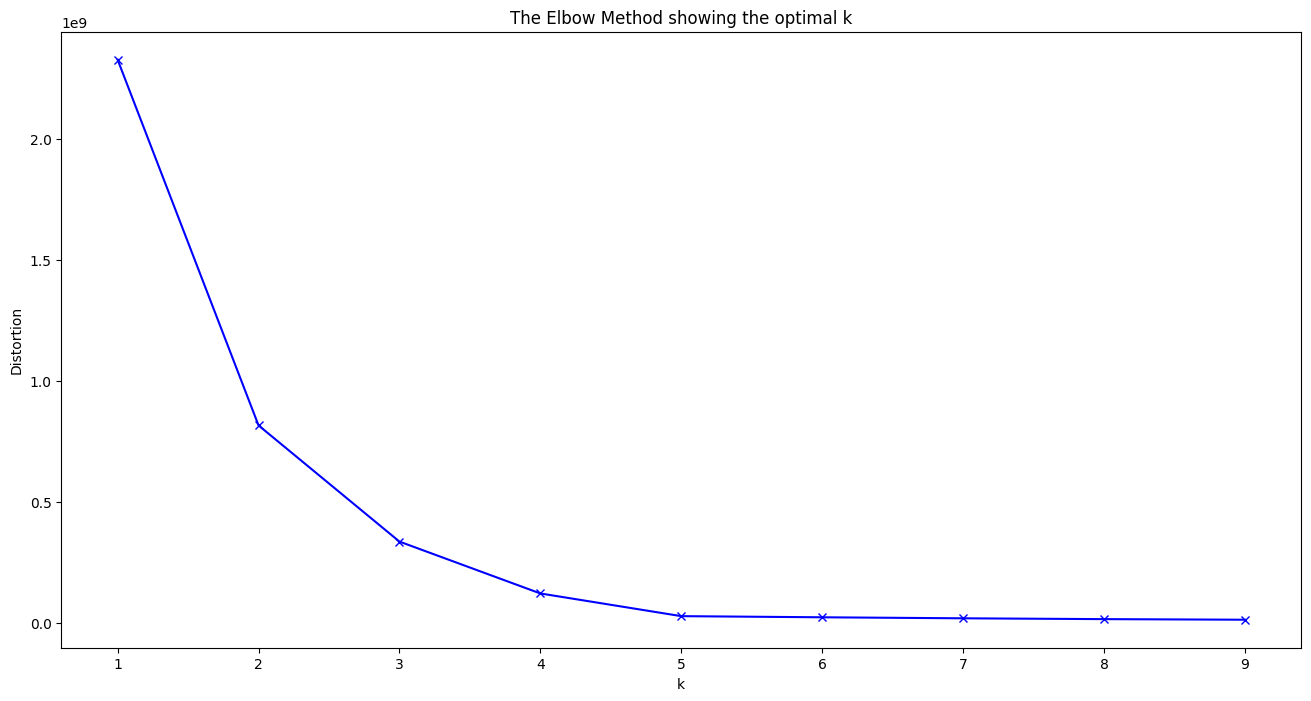

The optimal number of clusters is 3


c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


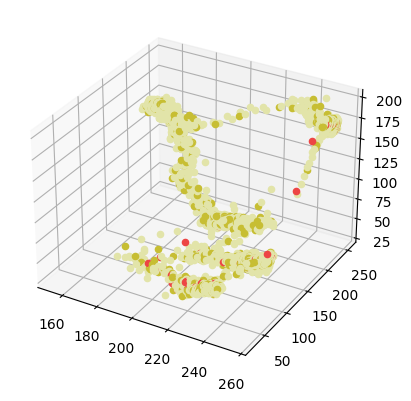

In [22]:
def visualize_clusters(image, labels, colors):
    r, g, b = cv2.split(image)
    r = r.flatten()
    g = g.flatten()
    b = b.flatten()

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    for label, pix in zip(labels, zip(r, g, b)):
        ax.scatter(pix[0], pix[1], pix[2], color = RGB2HEX(colors[label]))
    plt.show()

# Use the extract_colors_elbow function instead of extract_colors
rgb_colors, labels = extract_colors_elbow(image, False)
visualize_clusters(image, labels, rgb_colors)

### Run Kmean algorithm using <u>the Silhouetter method</u> to find the number of clusters ( 3rd option)
#### extract_colors_silhouette(image, show_chart):

In [26]:
from sklearn.metrics import silhouette_score

def extract_colors_silhouette(image, show_chart):
    # resize and reshape the image as before
    modified_image = cv2.resize(image, (600, 400), interpolation = cv2.INTER_AREA)
    modified_image = modified_image.reshape(modified_image.shape[0]*modified_image.shape[1], 3)

    # use the silhouette method to find the optimal number of clusters
    silhouette_scores = [] # to store the silhouette scores
    K = range(2,10) # the range of the number of clusters - OPTIMAL NUMBER
    for k in K: # for each number of clusters
        kmeanModel = KMeans(n_clusters=k) # create the model
        labels = kmeanModel.fit_predict(modified_image) # fit the model to the image data and predicts the cluster for each pixel
        score = silhouette_score(modified_image, labels) # calculate silhouette score
        silhouette_scores.append(score) # append the score to the list

    # plot the silhouette scores
    if show_chart:
        plt.figure(figsize=(16,8))
        plt.plot(K, silhouette_scores, 'bx-') # plot the number of clusters vs the silhouette scores
        plt.xlabel('k')
        plt.ylabel('Silhouette Score')
        plt.title('The Silhouette Method showing the optimal k')
        plt.show()

    # find the optimal number of clusters
    optimal_k = K[silhouette_scores.index(max(silhouette_scores))] # get the optimal number of clusters

    # Print the optimal number of clusters
    print(f'The optimal number of clusters is {optimal_k}')

    # create the model with the optimal number of clusters
    clf = KMeans(n_clusters = optimal_k)
    labels = clf.fit_predict(modified_image) # fit the model to the image data and predicts the cluster for each pixel

    counts = Counter(labels) # counts the number of pixels in each cluster
    counts = dict(sorted(counts.items())) # sort the counts by cluster number

    center_colors = clf.cluster_centers_ # get the cluster centers- the center color of each cluster
    ordered_colors = [center_colors[i] for i in counts.keys()] # orders the colors according to the sorted keys of the counts dictionary
    hex_colors = [RGB2HEX(ordered_colors[i]) for i in counts.keys()] # converts the RGB colors to HEX
    rgb_colors = [ordered_colors[i] for i in counts.keys()] # gets the RGB colors

    if (show_chart):
        plt.figure(figsize = (8, 6))
        plt.pie(counts.values(), labels = hex_colors, colors = hex_colors)

    return rgb_colors ,labels

In [27]:
extract_colors_silhouette(load_image('images_jpg\\colors.jpg'), True)

c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KeyboardInterrupt: 

### Run Kmean algorithm using <u>the Gap statistic</u> to find the number of clusters ( 4th option)
#### calculate_gap_statistic(X):

In [ ]:
from sklearn.cluster import KMeans
import numpy as np
from scipy.spatial.distance import cdist, pdist
from matplotlib import pyplot as plt
import pandas as pd

def calculate_gap_statistic(image):
    # Load the image
    image = cv2.imread('path_to_your_image.jpg')

    # Resize the image
    image = cv2.resize(image, (600, 400), interpolation = cv2.INTER_AREA)

    # Reshape the image to be a list of RGB values
    image = image.reshape(image.shape[0]*image.shape[1], 3)
    
    gaps = []
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, gap in enumerate(range(1, 21)):
        # Run k-means
        kmeans = KMeans(gap).fit(image)
        
        # Calculate gap statistic
        actual_inertia = kmeans.inertia_
        reference_inertia = np.log(np.sum([cdist(image, kmeans.cluster_centers_, 'euclidean').min(axis=1) for i in range(10)]) / 10)
        gap = reference_inertia - np.log(actual_inertia)
        
        # Append the gap statistic to gaps
        gaps.append(gap)
        
        resultsdf = resultsdf.append({'clusterCount':gap, 'gap':gap}, ignore_index=True)
    
    return gaps, resultsdf

gaps, resultsdf = calculate_gap_statistic(load_image('images_jpg\\colors.jpg'))
plt.plot(resultsdf.clusterCount, resultsdf.gap, linewidth=3)
plt.scatter(resultsdf[resultsdf.gap == resultsdf.gap.max()].clusterCount, resultsdf.gap.max(), s=250, c='r')
plt.grid(True)
plt.xlabel('Cluster Count')
plt.ylabel('Gap Value')
plt.title('Gap Values by Cluster Count')
plt.show()

### Find colors name according to hec code values and if some values dodn't have names then handling this otion by finding the closest color name

In [ ]:
hex_codes = extract_colors_elbow()
plot_color_pie_chart(hex_codes)

### Metrics 
We use them to evaluate the quality and performance of the algorithm . Below are some of the metrics :

##### CIE76 forlmula 
Delta E is a metric for understanding how the human eye perceives color difference. 

In [ ]:
from skimage import color
import numpy as np

def rgb2lab(inputColor):
    num = 0
    RGB = [0, 0, 0]

    for value in inputColor:
        value = float(value) / 255

        if value > 0.04045:
            value = ((value + 0.055) / 1.055) ** 2.4
        else:
            value = value / 12.92

        RGB[num] = value * 100
        num = num + 1

    XYZ = [0, 0, 0,]

    X = RGB[0] * 0.4124 + RGB[1] * 0.3576 + RGB[2] * 0.1805
    Y = RGB[0] * 0.2126 + RGB[1] * 0.7152 + RGB[2] * 0.0722
    Z = RGB[0] * 0.0193 + RGB[1] * 0.1192 + RGB[2] * 0.9505
    XYZ[0] = round(X, 4)
    XYZ[1] = round(Y, 4)
    XYZ[2] = round(Z, 4)

    XYZ[0] = float(XYZ[0]) / 95.047         # ref_X =  95.047   Observer= 2°, Illuminant= D65
    XYZ[1] = float(XYZ[1]) / 100.0          # ref_Y = 100.000
    XYZ[2] = float(XYZ[2]) / 108.883        # ref_Z = 108.883

    num = 0
    for value in XYZ:
        if value > 0.008856:
            value = value ** (0.3333333333333333)
        else:
            value = (7.787 * value) + (16 / 116)

        XYZ[num] = value
        num = num + 1

    Lab = [0, 0, 0]

    L = (116 * XYZ[1]) - 16
    a = 500 * (XYZ[0] - XYZ[1])
    b = 200 * (XYZ[1] - XYZ[2])

    Lab [0] = round(L, 4)
    Lab [1] = round(a, 4)
    Lab [2] = round(b, 4)

    return Lab

def delta_e_cie76(lab1, lab2):
    return np.sqrt(np.sum((np.array(lab1) - np.array(lab2)) ** 2))

# Example usage:
color1_rgb = [255, 255, 255]
color2_rgb = [255, 254, 253]

color1_lab = rgb2lab(color1_rgb)
color2_lab = rgb2lab(color2_rgb)

delta_e = delta_e_cie76(color1_lab, color2_lab)
print(delta_e)

0.6807638210128408


## Conclusion

In this notebook, we used KMeans to extract majority colors from images. We then used the RGB Values of Colors to identify images from a collection that have that color in them.